In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahboobmustafa","key":"6c497a86c547a845eee466d0ac62836c"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 70 Nov 19 15:17 kaggle.json
{"username":"mahboobmustafa","key":"6c497a86c547a845eee466d0ac62836c"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 5.3MB 16.9MB/s 
     |████████████████████████████████| 112kB 68.1MB/s 
     |████████████████████████████████| 112kB 68.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 


In [0]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [02:06<00:00, 86.6MB/s]
100% 7.25G/7.25G [02:06<00:00, 61.7MB/s]


In [0]:
!unzip diabetic-retinopathy-resized.zip

In [0]:
import glob
print(len(glob.glob('resized_train/resized_train/*')))
print(len(glob.glob('resized_train_cropped/resized_train_cropped/*')))

0
35108


In [0]:
!rm -rf resized_train
! rm -rf trainLabels.csv

In [0]:
import os
from glob import glob
from skimage.io import imread

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

%matplotlib inline 

from keras.utils.np_utils import to_categorical

# Tensorflow, Sklearn & Keras related imports
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.applications.inception_v3 import preprocess_input

from keras.applications.vgg16 import VGG16
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
labels = pd.read_csv('trainLabels_cropped.csv')
updated_labels = pd.DataFrame()
updated_labels['image'] = labels['image']
updated_labels['level'] = labels['level']

In [0]:
root_directory = './colored'

In [0]:
check_path = os.path.exists
split_name = lambda x: x.split('_')[0]
image_path = lambda x: os.path.join(root_directory,'{}.jpeg'.format(x))
get_level  = lambda x: to_categorical(x,1+dataset['level'].max())
check_left_or_right = lambda x: 1 if x.split('_')[-1]=='left' else 0
resample_data = lambda x: x.sample(300, replace = True)

In [0]:
dataset = pd.DataFrame()

dataset['image'] = updated_labels['image']
dataset['level'] = updated_labels['level']

dataset['p_id'] = updated_labels['image'].map(split_name)
dataset['path'] = updated_labels['image'].map(image_path)

dataset['path_exists'] = dataset['path'].map(check_path)
dataset['l_r_eye'] = dataset['image'].map(check_left_or_right)
dataset['level_cat'] = dataset['level'].map(get_level)

In [0]:
print(dataset.shape)
# Removing nulls and rows where path does not exist (since we are working on a subset)
dataset.dropna(inplace = True)
dataset = dataset[dataset['path_exists']]
print(dataset.shape)

(35108, 7)
(2500, 7)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c733355c0>,
      dtype=object)

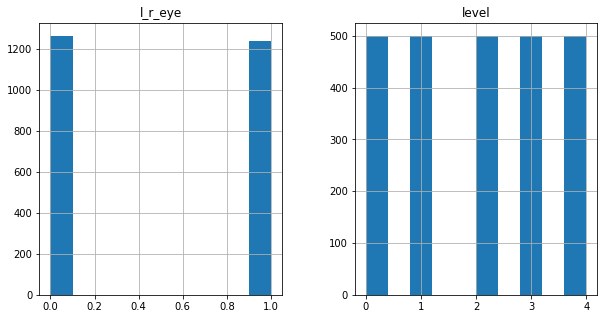

In [0]:
dataset[['level', 'l_r_eye']].hist(figsize=(10,5))

In [0]:
# Splitting dataset on the basis of IDs (train+validation)
train_ids, valid_ids = train_test_split(dataset['p_id'], test_size = 0.25, random_state = 2018, stratify = dataset['level'])

# Splitting dataframe on the basis of train & validation IDs
raw_train_df = dataset[dataset['p_id'].isin(train_ids)]
valid_df = dataset[dataset['p_id'].isin(valid_ids)]

print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 1988 validation 738


In [0]:
train_df = raw_train_df.copy()

New Data Size: 3000 Old Size: 33020


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f559d4e0>]],
      dtype=object)

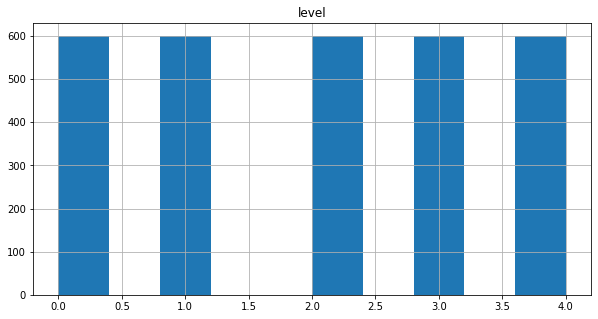

In [0]:
train_df = raw_train_df.groupby(['level', 'l_r_eye']).apply(resample_data).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level']].hist(figsize = (10, 5))

In [0]:
import cv2

def grayscale(X):
    image = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (512, 512))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0), 512/10), -4, 128)
    print(type(X))
    return image

def load_color(X, sigmaX=30):
    image = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512, 512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


In [0]:
def load_images(out_size, horizontal_flip = True, vertical_flip = False, random_brightness = True,random_contrast = True,
                    random_saturation = True,random_hue = True,color_mode = 'rgb',preproc_func = preprocess_input,on_batch = False):
    
    def augment_image(X): # where X is an image_path; return augmentations
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                X = tf.image.random_flip_left_right(X) if horizontal_flip else X
                X = tf.image.random_flip_up_down(X) if vertical_flip else X
                # X = tf.image.random_brightness(X, max_delta = 0.1) if vertical_flip else X
                # X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5) if random_saturation else X
                # X = tf.image.random_hue(X, max_delta = 0.15) if random_hue else X
                # X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5) if random_contrast else X
                return preproc_func(X)
    
    def _batch_func(X, y):
        return tf.map_fn(augment_image, X), y
    
    def _all_func(X, y):
        return augment_image(X), y   
    
    return _batch_func(X,y) if on_batch else _all_func

In [0]:
def augmentor(out_size,intermediate_size = (640, 640),intermediate_trans = 'crop',batch_size = 16,horizontal_flip = True, vertical_flip = False, random_brightness = True, random_contrast = True,
                 random_saturation = True,random_hue = True,color_mode = 'rgb',preproc_func = preprocess_input, min_crop_percent = 0.001,max_crop_percent = 0.005,crop_probability = 0.5,
                rotation_range = 10):
    
    load_operations = load_images(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_operations(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]
            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,tf.contrib.image.compose_transforms(*transforms),interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_operations, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_operations)
    return _create_pipeline

In [0]:
def flow_df(idg, in_df, path_col,y_col, shuffle = True, color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        
        for i in range(max(in_len//32,1)):
            yield K.get_session().run(next_batch)

In [0]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [0]:
core_idg = augmentor(out_size = IMAGE_SIZE, color_mode = 'rgb', vertical_flip = True,crop_probability=0.0, batch_size = BATCH_SIZE) 
valid_idg = augmentor(out_size = IMAGE_SIZE, color_mode = 'rgb', crop_probability=0.0, horizontal_flip = False, vertical_flip = False, random_brightness = False,
                         random_contrast = False,random_saturation = False,random_hue = False,rotation_range = 0,batch_size = BATCH_SIZE)

# Generating data flow to generate data
train_gen = flow_df(core_idg, train_df, path_col = 'path', y_col = 'level_cat')
valid_gen = flow_df(valid_idg, valid_df, path_col = 'path', y_col = 'level_cat') 




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.






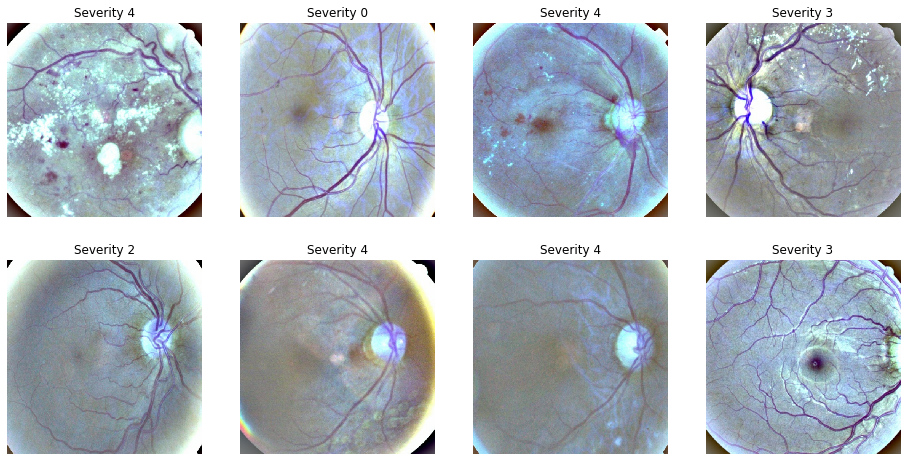

In [0]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

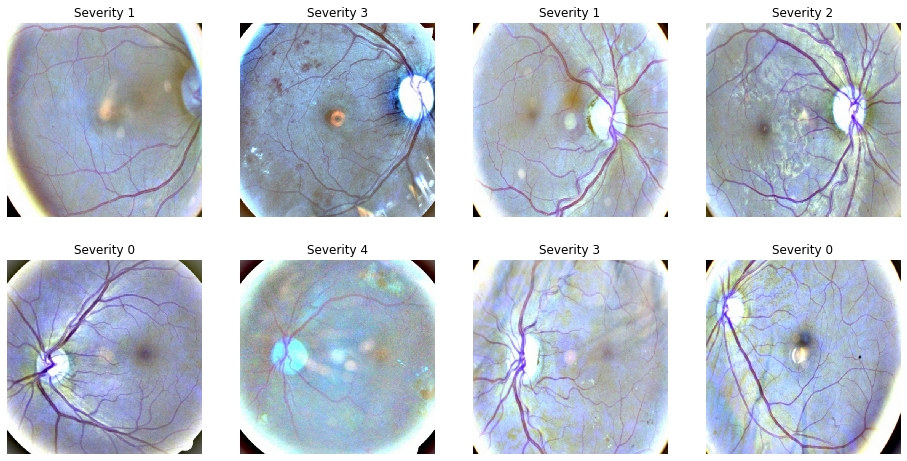

In [0]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [0]:
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

In [0]:
def create_attention_w_inceptionV3_model():
    in_lay = Input(t_x.shape[1:])
    
    base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    pt_features = base_pretrained_model(in_lay)
    
    bn_features = BatchNormalization()(pt_features)

    # here we do an attention mechanism to turn pixels in the GAP on an off

    # attention_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
    # attention_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attention_layer)
    # attention_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attention_layer)
    # attention_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attention_layer)
    
    # # fan it out to all of the channels
    # up_c2_w = np.ones((1, 1, 1, pt_depth))
    # up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
    # up_c2.trainable = False
    
    # attention_layer = up_c2(attention_layer)

    # mask_features = multiply([attention_layer, bn_features])
    
    # gap_features = GlobalAveragePooling2D()(mask_features)
    # gap_mask = GlobalAveragePooling2D()(attention_layer)
    
    # # to account for missing values from the attention model
    # gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    # gap_dr = Dropout(0.25)(gap)
    # dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
    #dr_steps = (Dense(128, activation = 'relu')(attention_layer))

    output_layer = Dense(t_y.shape[-1], activation = 'softmax')(attention_layer)
    classifier = Model(inputs = [in_lay], outputs = [output_layer])
    
    
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy', top_2_accuracy])
    print(classifier.summary())
    return classifier

In [0]:
weight_path="dr_weights.best.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", mode="min", patience=6) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
classifier = create_attention_w_inceptionV3_model()

NameError: ignored

In [0]:
classifier.fit_generator(train_gen, 
                            steps_per_epoch = train_df.shape[0]//BATCH_SIZE,
                            validation_data = valid_gen, 
                            validation_steps = valid_df.shape[0]//BATCH_SIZE,
                            epochs = 25, 
                            callbacks = callbacks_list,
                            workers = 0,
                            use_multiprocessing=True, 
                            max_queue_size = 0
                            )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
62/62 [==============================] - 184s 3s/step - loss: 1.4920 - categorical_accuracy: 0.3357 - top_2_accuracy: 0.5817 - val_loss: 2.1867 - val_categorical_accuracy: 0.2024 - val_top_2_accuracy: 0.4117

Epoch 00001: val_loss improved from inf to 2.18673, saving model to dr_weights.best.hdf5
Epoch 2/25
62/62 [==============================] - 171s 3s/step - loss: 1.3074 - categorical_accuracy: 0.4244 - top_2_accuracy: 0.6734 - val_loss: 2.4137 - val_categorical_accuracy: 0.2024 - val_top_2_accuracy: 0.4022

Epoch 00002: val_loss did not improve from 2.18673
Epoch 3/25
62/62 [==============================] - 172s 3s/step - loss: 1.2627 - categorical_accuracy: 0.4481 - top_2_accuracy: 0.7117 - val_loss: 2.7358 - val_categorical_accuracy: 0.1957 - val_top_2_accuracy: 0.4239

Epoch 00003: val_loss did not improve from 2.18673
Epoch 4/25
11/62 [====>.........................] - E

KeyboardInterrupt: ignored

In [0]:
!mkdir grays

In [0]:
from glob import glob

base = './resized_train_cropped/resized_train_cropped/*'
for im in glob(base):
    image = cv2.imread(im)
    im_name = './grays/'+im.split("/")[-1]
    cv2.imwrite(im_name, grayscale(image))

In [0]:
!rm -rf grays

In [0]:
level_0_samples = dataset[dataset['level']==0].sample(n=500)
level_1_samples = dataset[dataset['level']==1].sample(n=500)
level_2_samples = dataset[dataset['level']==2].sample(n=500)
level_3_samples = dataset[dataset['level']==3].sample(n=500)
level_4_samples = dataset[dataset['level']==4].sample(n=500)

In [0]:
paths = [level_0_samples['path'], level_1_samples['path'], level_2_samples['path'], level_3_samples['path'], level_4_samples['path']]

In [0]:
len(paths)

5

In [0]:
count = 0
for x in paths:
    for path in x:
        image = cv2.imread(path)
        im_name = './grays/'+path.split("/")[-1]
        cv2.imwrite(im_name, grayscale(image))
        count += 1
        print("Done: {}".format(count))


In [0]:
!mkdir colored

In [0]:
count = 0
for x in paths:
    for path in x:
        image = cv2.imread(path)
        im_name = './colored/'+path.split("/")[-1]
        cv2.imwrite(im_name, load_ben_color(image, 30))
        count += 1
        print("Done: {}".format(count))


In [0]:
!zip -r colored.zip ./colored

In [0]:
!zip -r grays.zip grays

In [0]:
files.download('./colored.zip')

In [0]:
files.download('./grays.zip')